<a href="https://colab.research.google.com/github/Khushgod/Furniture-Product-Analysis/blob/main/Furniture_Analysis_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import re
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
warnings.filterwarnings('ignore')

class FurnitureAnalysisPipeline:
    def __init__(self, data_path):
        """
        Initialize the Furniture Analysis Pipeline

        Parameters:
        data_path (str): Path to the CSV file containing furniture data
        """
        self.data_path = data_path
        self.df = None
        self.processed_data = {}

    def load_and_explore_data(self):
        """Load data and perform comprehensive initial exploration"""
        print("="*80)
        print("FURNITURE DATASET - COMPREHENSIVE ANALYSIS")
        print("="*80)

        # Load data
        self.df = pd.read_csv(self.data_path)
        print(f"✅ Dataset loaded successfully!")
        print(f"📊 Shape: {self.df.shape[0]:,} products × {self.df.shape[1]} features")

        # Display column information
        print(f"\n📋 Column Information:")
        for i, col in enumerate(self.df.columns, 1):
            print(f"  {i}. {col}")

        print(f"\n🔍 Data Types:")
        for col, dtype in self.df.dtypes.items():
            print(f"  {col}: {dtype}")

        # Basic statistics
        print(f"\n📈 Dataset Overview:")
        print(f"  • Total products: {len(self.df):,}")
        print(f"  • Unique product titles: {self.df['productTitle'].nunique():,}")
        print(f"  • Date range: Not specified in current dataset")
        print(f"  • Memory usage: {self.df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        # Data quality assessment
        print(f"\n🔍 Data Quality Assessment:")
        print("="*50)

        # Missing values
        missing_data = self.df.isnull().sum()
        total_missing = missing_data.sum()

        if total_missing > 0:
            print("❌ Missing Values Found:")
            for col, missing in missing_data.items():
                if missing > 0:
                    percentage = (missing / len(self.df)) * 100
                    print(f"  {col}: {missing:,} ({percentage:.2f}%)")
        else:
            print("✅ No missing values detected!")

        # Duplicate records
        duplicates = self.df.duplicated().sum()
        if duplicates > 0:
            print(f"⚠️  Duplicate records: {duplicates:,} ({duplicates/len(self.df)*100:.2f}%)")
        else:
            print("✅ No duplicate records found!")

        # Data validation
        print(f"\n📊 Data Validation:")

        # Price validation
        if 'originalPrice' in self.df.columns and 'price' in self.df.columns:
            # Convert price columns to numeric, handling any text
            self.df['originalPrice'] = pd.to_numeric(self.df['originalPrice'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
            self.df['price'] = pd.to_numeric(self.df['price'].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')

            negative_original = (self.df['originalPrice'] < 0).sum()
            negative_current = (self.df['price'] < 0).sum()
            price_higher_than_original = (self.df['price'] > self.df['originalPrice']).sum()

            print(f"  • Negative original prices: {negative_original}")
            print(f"  • Negative current prices: {negative_current}")
            print(f"  • Current price > original price: {price_higher_than_original}")

        # Sales validation
        if 'sold' in self.df.columns:
            self.df['sold'] = pd.to_numeric(self.df['sold'].astype(str).str.replace(r'[^\d]', '', regex=True), errors='coerce')
            negative_sales = (self.df['sold'] < 0).sum()
            zero_sales = (self.df['sold'] == 0).sum()
            print(f"  • Negative sales: {negative_sales}")
            print(f"  • Zero sales: {zero_sales} ({zero_sales/len(self.df)*100:.2f}%)")

        # Display sample data
        print(f"\n📋 Sample Data (First 5 Records):")
        print("="*80)
        display_df = self.df.head()
        for col in display_df.columns:
            if display_df[col].dtype == 'object':
                display_df[col] = display_df[col].astype(str).str[:50] + '...'
        print(display_df.to_string(index=False))

        return self.df

    def analyze_pricing_strategy(self):
        """Analyze pricing patterns and discount strategies"""
        print("\n" + "="*80)
        print("PRICING STRATEGY ANALYSIS")
        print("="*80)

        # Calculate discount metrics
        self.df['discount_amount'] = self.df['originalPrice'] - self.df['price']
        self.df['discount_percentage'] = (self.df['discount_amount'] / self.df['originalPrice'] * 100).round(2)

        # Handle edge cases
        self.df['discount_percentage'] = self.df['discount_percentage'].fillna(0)
        self.df['discount_percentage'] = np.where(self.df['discount_percentage'] < 0, 0, self.df['discount_percentage'])

        # Basic pricing statistics
        print("💰 PRICING OVERVIEW:")
        print(f"  • Average Original Price: ${self.df['originalPrice'].mean():.2f}")
        print(f"  • Average Current Price: ${self.df['price'].mean():.2f}")
        print(f"  • Median Original Price: ${self.df['originalPrice'].median():.2f}")
        print(f"  • Median Current Price: ${self.df['price'].median():.2f}")
        print(f"  • Price Range: ${self.df['price'].min():.2f} - ${self.df['price'].max():,.2f}")

        # Discount analysis
        print(f"\n🏷️ DISCOUNT ANALYSIS:")
        avg_discount = self.df['discount_percentage'].mean()
        median_discount = self.df['discount_percentage'].median()

        print(f"  • Average Discount: {avg_discount:.1f}%")
        print(f"  • Median Discount: {median_discount:.1f}%")
        print(f"  • Max Discount: {self.df['discount_percentage'].max():.1f}%")

        # Discount categories
        no_discount = (self.df['discount_percentage'] == 0).sum()
        small_discount = ((self.df['discount_percentage'] > 0) & (self.df['discount_percentage'] <= 20)).sum()
        medium_discount = ((self.df['discount_percentage'] > 20) & (self.df['discount_percentage'] <= 50)).sum()
        large_discount = (self.df['discount_percentage'] > 50).sum()

        print(f"\n📊 DISCOUNT CATEGORIES:")
        print(f"  • No Discount (0%): {no_discount:,} products ({no_discount/len(self.df)*100:.1f}%)")
        print(f"  • Small Discount (1-20%): {small_discount:,} products ({small_discount/len(self.df)*100:.1f}%)")
        print(f"  • Medium Discount (21-50%): {medium_discount:,} products ({medium_discount/len(self.df)*100:.1f}%)")
        print(f"  • Large Discount (50%+): {large_discount:,} products ({large_discount/len(self.df)*100:.1f}%)")

        # Price tiers analysis
        self.df['price_tier'] = pd.cut(self.df['price'],
                                      bins=[0, 25, 50, 100, 200, float('inf')],
                                      labels=['Budget ($0-25)', 'Low ($25-50)', 'Mid ($50-100)',
                                             'High ($100-200)', 'Premium ($200+)'])

        tier_analysis = self.df['price_tier'].value_counts().sort_index()
        print(f"\n💎 PRICE TIER DISTRIBUTION:")
        for tier, count in tier_analysis.items():
            percentage = count / len(self.df) * 100
            print(f"  • {tier}: {count:,} products ({percentage:.1f}%)")

        # Store results
        self.processed_data['pricing'] = {
            'avg_original_price': self.df['originalPrice'].mean(),
            'avg_current_price': self.df['price'].mean(),
            'avg_discount': avg_discount,
            'discount_categories': {
                'no_discount': no_discount,
                'small_discount': small_discount,
                'medium_discount': medium_discount,
                'large_discount': large_discount
            },
            'price_tiers': tier_analysis
        }

        return self.df

    def analyze_sales_performance(self):
        """Analyze sales patterns and performance metrics"""
        print("\n" + "="*80)
        print("SALES PERFORMANCE ANALYSIS")
        print("="*80)

        # Sales statistics
        total_units_sold = self.df['sold'].sum()
        avg_sales_per_product = self.df['sold'].mean()
        median_sales = self.df['sold'].median()

        print("📈 SALES OVERVIEW:")
        print(f"  • Total Units Sold: {total_units_sold:,}")
        print(f"  • Average Sales per Product: {avg_sales_per_product:.1f}")
        print(f"  • Median Sales per Product: {median_sales:.0f}")
        print(f"  • Sales Range: {self.df['sold'].min()} - {self.df['sold'].max():,} units")

        # Revenue analysis
        self.df['revenue'] = self.df['price'] * self.df['sold']
        self.df['potential_revenue'] = self.df['originalPrice'] * self.df['sold']
        self.df['revenue_lost_to_discount'] = self.df['potential_revenue'] - self.df['revenue']

        total_revenue = self.df['revenue'].sum()
        potential_revenue = self.df['potential_revenue'].sum()
        revenue_lost = self.df['revenue_lost_to_discount'].sum()

        print(f"\n💵 REVENUE ANALYSIS:")
        print(f"  • Total Revenue: ${total_revenue:,.2f}")
        print(f"  • Potential Revenue (without discounts): ${potential_revenue:,.2f}")
        print(f"  • Revenue Lost to Discounts: ${revenue_lost:,.2f} ({revenue_lost/potential_revenue*100:.1f}%)")
        print(f"  • Average Revenue per Product: ${self.df['revenue'].mean():.2f}")

        # Sales performance categories
        zero_sales = (self.df['sold'] == 0).sum()
        low_sales = ((self.df['sold'] > 0) & (self.df['sold'] <= 10)).sum()
        medium_sales = ((self.df['sold'] > 10) & (self.df['sold'] <= 50)).sum()
        high_sales = ((self.df['sold'] > 50) & (self.df['sold'] <= 200)).sum()
        very_high_sales = (self.df['sold'] > 200).sum()

        print(f"\n🎯 SALES PERFORMANCE CATEGORIES:")
        print(f"  • No Sales (0): {zero_sales:,} products ({zero_sales/len(self.df)*100:.1f}%)")
        print(f"  • Low Sales (1-10): {low_sales:,} products ({low_sales/len(self.df)*100:.1f}%)")
        print(f"  • Medium Sales (11-50): {medium_sales:,} products ({medium_sales/len(self.df)*100:.1f}%)")
        print(f"  • High Sales (51-200): {high_sales:,} products ({high_sales/len(self.df)*100:.1f}%)")
        print(f"  • Very High Sales (200+): {very_high_sales:,} products ({very_high_sales/len(self.df)*100:.1f}%)")

        # Top performers
        print(f"\n🏆 TOP 10 BEST SELLING PRODUCTS:")
        top_sellers = self.df.nlargest(10, 'sold')[['productTitle', 'price', 'sold', 'revenue']]
        for idx, (_, row) in enumerate(top_sellers.iterrows(), 1):
            title = row['productTitle'][:50] + "..." if len(row['productTitle']) > 50 else row['productTitle']
            print(f"  {idx}. {title}")
            print(f"      Price: ${row['price']:.2f} | Sold: {row['sold']:,} | Revenue: ${row['revenue']:.2f}")

        print(f"\n💰 TOP 10 HIGHEST REVENUE PRODUCTS:")
        top_revenue = self.df.nlargest(10, 'revenue')[['productTitle', 'price', 'sold', 'revenue']]
        for idx, (_, row) in enumerate(top_revenue.iterrows(), 1):
            title = row['productTitle'][:50] + "..." if len(row['productTitle']) > 50 else row['productTitle']
            print(f"  {idx}. {title}")
            print(f"      Price: ${row['price']:.2f} | Sold: {row['sold']:,} | Revenue: ${row['revenue']:.2f}")

        # Store results
        self.processed_data['sales'] = {
            'total_units_sold': total_units_sold,
            'avg_sales_per_product': avg_sales_per_product,
            'total_revenue': total_revenue,
            'revenue_lost': revenue_lost,
            'top_sellers': top_sellers,
            'top_revenue': top_revenue
        }

        return self.df

    def analyze_product_categories(self):
        """Analyze product categories and furniture types"""
        print("\n" + "="*80)
        print("PRODUCT CATEGORY ANALYSIS")
        print("="*80)

        # Extract furniture types from product titles
        furniture_keywords = [
            'chair', 'table', 'sofa', 'bed', 'desk', 'shelf', 'cabinet', 'dresser',
            'nightstand', 'wardrobe', 'bookshelf', 'stool', 'bench', 'ottoman',
            'dining', 'office', 'bedroom', 'living room', 'kitchen', 'storage',
            'lamp', 'mirror', 'rack', 'stand', 'organizer', 'cushion', 'mattress',
            'frame', 'drawer', 'cupboard', 'armchair', 'coffee table', 'side table'
        ]

        # Create category classification
        self.df['product_category'] = 'Other'
        self.df['title_lower'] = self.df['productTitle'].str.lower()

        # Categorize products
        category_mapping = {
            'Seating': ['chair', 'sofa', 'stool', 'bench', 'ottoman', 'armchair'],
            'Tables': ['table', 'desk', 'coffee table', 'side table', 'dining'],
            'Storage': ['shelf', 'cabinet', 'dresser', 'wardrobe', 'bookshelf', 'storage', 'rack', 'organizer', 'drawer', 'cupboard'],
            'Bedroom': ['bed', 'nightstand', 'mattress', 'bedroom'],
            'Lighting': ['lamp'],
            'Decor': ['mirror', 'cushion', 'frame'],
            'Office': ['office', 'desk']
        }

        for category, keywords in category_mapping.items():
            mask = self.df['title_lower'].str.contains('|'.join(keywords), na=False)
            self.df.loc[mask, 'product_category'] = category

        # Category analysis
        category_stats = self.df.groupby('product_category').agg({
            'productTitle': 'count',
            'price': ['mean', 'median'],
            'sold': ['sum', 'mean'],
            'revenue': 'sum',
            'discount_percentage': 'mean'
        }).round(2)

        category_stats.columns = ['Product_Count', 'Avg_Price', 'Median_Price',
                                 'Total_Sales', 'Avg_Sales', 'Total_Revenue', 'Avg_Discount']
        category_stats = category_stats.sort_values('Total_Revenue', ascending=False)

        print("🏷️ PRODUCT CATEGORY PERFORMANCE:")
        print("="*60)
        for category, stats in category_stats.iterrows():
            print(f"📦 {category}:")
            print(f"  • Products: {stats['Product_Count']:,}")
            print(f"  • Avg Price: ${stats['Avg_Price']:.2f}")
            print(f"  • Total Sales: {stats['Total_Sales']:,} units")
            print(f"  • Total Revenue: ${stats['Total_Revenue']:,.2f}")
            print(f"  • Avg Discount: {stats['Avg_Discount']:.1f}%")
            print()

        # Market share analysis
        print("📊 MARKET SHARE BY CATEGORY:")
        total_revenue = self.df['revenue'].sum()
        for category, stats in category_stats.iterrows():
            market_share = (stats['Total_Revenue'] / total_revenue) * 100
            print(f"  • {category}: {market_share:.1f}% of total revenue")

        # Store results
        self.processed_data['categories'] = {
            'category_stats': category_stats,
            'total_categories': len(category_stats)
        }

        return self.df

    def analyze_tag_text_impact(self):
        """Analyze the impact of tags on sales performance"""
        print("\n" + "="*80)
        print("TAG TEXT IMPACT ANALYSIS")
        print("="*80)

        # Clean and analyze tags
        if 'tagText' in self.df.columns:
            # Handle missing tags
            self.df['tagText'] = self.df['tagText'].fillna('No Tags')
            self.df['has_tags'] = self.df['tagText'] != 'No Tags'

            # Extract common tags
            all_tags = []
            for tag_text in self.df['tagText']:
                if pd.notna(tag_text) and tag_text != 'No Tags':
                    # Split by common delimiters
                    tags = re.split(r'[,;|]', str(tag_text))
                    all_tags.extend([tag.strip().lower() for tag in tags if tag.strip()])

            # Tag frequency analysis
            tag_counter = Counter(all_tags)
            top_tags = dict(tag_counter.most_common(15))

            print("🏷️ MOST COMMON TAGS:")
            for i, (tag, count) in enumerate(top_tags.items(), 1):
                percentage = (count / len(self.df)) * 100
                print(f"  {i:2d}. '{tag}': {count:,} products ({percentage:.1f}%)")

            # Tag impact on sales
            tagged_products = self.df[self.df['has_tags'] == True]
            untagged_products = self.df[self.df['has_tags'] == False]

            print(f"\n📈 TAG IMPACT ON PERFORMANCE:")
            print(f"  Products with tags: {len(tagged_products):,} ({len(tagged_products)/len(self.df)*100:.1f}%)")
            print(f"  Products without tags: {len(untagged_products):,} ({len(untagged_products)/len(self.df)*100:.1f}%)")

            if len(tagged_products) > 0 and len(untagged_products) > 0:
                tagged_avg_sales = tagged_products['sold'].mean()
                untagged_avg_sales = untagged_products['sold'].mean()
                tagged_avg_price = tagged_products['price'].mean()
                untagged_avg_price = untagged_products['price'].mean()

                print(f"\n📊 PERFORMANCE COMPARISON:")
                print(f"  Tagged Products:")
                print(f"    • Avg Sales: {tagged_avg_sales:.1f} units")
                print(f"    • Avg Price: ${tagged_avg_price:.2f}")
                print(f"  Untagged Products:")
                print(f"    • Avg Sales: {untagged_avg_sales:.1f} units")
                print(f"    • Avg Price: ${untagged_avg_price:.2f}")

                # Statistical significance test
                if len(tagged_products['sold']) > 30 and len(untagged_products['sold']) > 30:
                    t_stat, p_value = stats.ttest_ind(tagged_products['sold'], untagged_products['sold'])
                    print(f"\n🔬 STATISTICAL TEST (Sales Difference):")
                    print(f"  • T-statistic: {t_stat:.3f}")
                    print(f"  • P-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print(f"  • Result: Statistically significant difference (p < 0.05)")
                    else:
                        print(f"  • Result: No statistically significant difference (p ≥ 0.05)")

            # Analyze specific high-impact tags
            print(f"\n🎯 HIGH-IMPACT TAG ANALYSIS:")
            for tag, count in list(top_tags.items())[:10]:
                if count >= 10:  # Only analyze tags with sufficient data
                    tag_products = self.df[self.df['tagText'].str.contains(tag, case=False, na=False)]
                    non_tag_products = self.df[~self.df['tagText'].str.contains(tag, case=False, na=False)]

                    if len(tag_products) > 0 and len(non_tag_products) > 0:
                        tag_avg_sales = tag_products['sold'].mean()
                        non_tag_avg_sales = non_tag_products['sold'].mean()
                        performance_lift = ((tag_avg_sales - non_tag_avg_sales) / non_tag_avg_sales) * 100

                        print(f"  '{tag}' ({count} products):")
                        print(f"    • Avg sales with tag: {tag_avg_sales:.1f}")
                        print(f"    • Avg sales without tag: {non_tag_avg_sales:.1f}")
                        print(f"    • Performance lift: {performance_lift:+.1f}%")

            # Store results
            self.processed_data['tags'] = {
                'top_tags': top_tags,
                'has_tags_performance': {
                    'tagged_avg_sales': tagged_avg_sales if len(tagged_products) > 0 else 0,
                    'untagged_avg_sales': untagged_avg_sales if len(untagged_products) > 0 else 0
                }
            }
        else:
            print("⚠️ No tagText column found in dataset")

        return self.df

    def perform_correlation_analysis(self):
        """Perform correlation analysis between key metrics"""
        print("\n" + "="*80)
        print("CORRELATION ANALYSIS")
        print("="*80)

        # Select numeric columns for correlation
        numeric_cols = ['originalPrice', 'price', 'sold', 'discount_amount',
                       'discount_percentage', 'revenue']

        # Calculate correlation matrix
        correlation_matrix = self.df[numeric_cols].corr()

        print("🔗 CORRELATION MATRIX:")
        print("="*60)
        print(correlation_matrix.round(3))

        # Identify strong correlations
        strong_correlations = []
        for i, col1 in enumerate(numeric_cols):
            for j, col2 in enumerate(numeric_cols[i+1:], i+1):
                corr_value = correlation_matrix.loc[col1, col2]
                if abs(corr_value) >= 0.3:  # Strong correlation threshold
                    strong_correlations.append((col1, col2, corr_value))

        print(f"\n💪 STRONG CORRELATIONS (|r| ≥ 0.3):")
        for col1, col2, corr in sorted(strong_correlations, key=lambda x: abs(x[2]), reverse=True):
            direction = "Positive" if corr > 0 else "Negative"
            strength = "Very Strong" if abs(corr) >= 0.7 else "Strong" if abs(corr) >= 0.5 else "Moderate"
            print(f"  • {col1} ↔ {col2}: {corr:.3f} ({strength} {direction})")

        # Key insights from correlations
        print(f"\n🔍 KEY CORRELATION INSIGHTS:")

        # Price vs Sales correlation
        price_sales_corr = correlation_matrix.loc['price', 'sold']
        print(f"  • Price vs Sales: {price_sales_corr:.3f}")
        if price_sales_corr < -0.2:
            print(f"    → Lower prices tend to drive higher sales")
        elif price_sales_corr > 0.2:
            print(f"    → Higher prices are associated with higher sales (premium effect)")
        else:
            print(f"    → Price has minimal impact on sales volume")

        # Discount vs Sales correlation
        discount_sales_corr = correlation_matrix.loc['discount_percentage', 'sold']
        print(f"  • Discount % vs Sales: {discount_sales_corr:.3f}")
        if discount_sales_corr > 0.2:
            print(f"    → Higher discounts drive more sales")
        elif discount_sales_corr < -0.2:
            print(f"    → Higher discounts are associated with lower sales")
        else:
            print(f"    → Discount percentage has minimal impact on sales")

        # Store results
        self.processed_data['correlations'] = {
            'correlation_matrix': correlation_matrix,
            'strong_correlations': strong_correlations,
            'price_sales_corr': price_sales_corr,
            'discount_sales_corr': discount_sales_corr
        }

        return correlation_matrix

    def perform_predictive_modeling(self):
        """Build predictive models for sales and revenue forecasting"""
        print("\n" + "="*80)
        print("PREDICTIVE MODELING")
        print("="*80)

        # Prepare features for modeling
        modeling_data = self.df.copy()

        # Create additional features
        modeling_data['price_to_original_ratio'] = modeling_data['price'] / modeling_data['originalPrice']
        modeling_data['title_length'] = modeling_data['productTitle'].str.len()

        # Handle has_tags feature
        if 'has_tags' in modeling_data.columns:
            modeling_data['has_tags_numeric'] = modeling_data['has_tags'].astype(int)
        else:
            modeling_data['has_tags_numeric'] = 0

        # Feature engineering for categories
        category_encoded = pd.get_dummies(modeling_data['product_category'], prefix='category')
        modeling_data = pd.concat([modeling_data, category_encoded], axis=1)

        # Select features for modeling
        feature_cols = ['originalPrice', 'price', 'discount_percentage', 'title_length',
                       'has_tags_numeric'] + [col for col in category_encoded.columns]

        # Remove any rows with missing values in feature columns
        modeling_data = modeling_data.dropna(subset=feature_cols + ['sold'])

        if len(modeling_data) > 100:  # Ensure sufficient data for modeling
            X = modeling_data[feature_cols]
            y = modeling_data['sold']

            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            print(f"📊 MODELING DATASET:")
            print(f"  • Training samples: {len(X_train):,}")
            print(f"  • Testing samples: {len(X_test):,}")
            print(f"  • Features: {len(feature_cols)}")

            # Model 1: Linear Regression
            lr_model = LinearRegression()
            lr_model.fit(X_train, y_train)
            lr_pred = lr_model.predict(X_test)
            lr_r2 = r2_score(y_test, lr_pred)
            lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))

            # Model 2: Random Forest
            rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)
            rf_pred = rf_model.predict(X_test)
            rf_r2 = r2_score(y_test, rf_pred)
            rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))

            print(f"\n🤖 MODEL PERFORMANCE:")
            print(f"Linear Regression:")
            print(f"  • R² Score: {lr_r2:.3f}")
            print(f"  • RMSE: {lr_rmse:.2f} units")
            print(f"Random Forest:")
            print(f"  • R² Score: {rf_r2:.3f}")
            print(f"  • RMSE: {rf_rmse:.2f} units")

            # Feature importance (Random Forest)
            feature_importance = pd.DataFrame({
                'feature': feature_cols,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\n🔍 FEATURE IMPORTANCE (Top 10):")
            for idx, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
                print(f"  {idx:2d}. {row['feature']}: {row['importance']:.4f}")

            # Model insights
            print(f"\n💡 MODELING INSIGHTS:")
            if rf_r2 > lr_r2:
                print(f"  • Random Forest outperforms Linear Regression")
                print(f"  • This suggests non-linear relationships in the data")
            else:
                print(f"  • Linear Regression performs similarly to Random Forest")
                print(f"  • Relationships in data appear to be mostly linear")

            if rf_r2 > 0.3:
                print(f"  • Model shows good predictive power (R² > 0.3)")
            elif rf_r2 > 0.1:
                print(f"  • Model shows moderate predictive power")
            else:
                print(f"  • Model shows limited predictive power")
                print(f"  • Sales may be influenced by factors not captured in data")

            # Store results
            self.processed_data['modeling'] = {
                'lr_r2': lr_r2,
                'rf_r2': rf_r2,
                'lr_rmse': lr_rmse,
                'rf_rmse': rf_rmse,
                'feature_importance': feature_importance,
                'best_model': 'Random Forest' if rf_r2 > lr_r2 else 'Linear Regression'
            }

        else:
            print("⚠️ Insufficient data for reliable modeling (< 100 samples)")

        return self.df

    def perform_customer_segmentation(self):
        """Perform customer segmentation based on price and sales patterns"""
        print("\n" + "="*80)
        print("PRODUCT SEGMENTATION ANALYSIS")
        print("="*80)

        # Prepare data for clustering
        segmentation_data = self.df[['price', 'sold', 'discount_percentage']].copy()
        segmentation_data = segmentation_data.fillna(0)

        # Standardize features
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(segmentation_data)

        # Determine optimal number of clusters using elbow method
        inertias = []
        k_range = range(2, 8)

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(scaled_data)
            inertias.append(kmeans.inertia_)

        # Use 4 clusters as default (typical for business segmentation)
        optimal_k = 4

        # Perform clustering
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
        self.df['segment'] = kmeans.fit_predict(scaled_data)

        print(f"🎯 PRODUCT SEGMENTS (K-Means with {optimal_k} clusters):")
        print("="*60)

        # Analyze each segment
        segment_analysis = self.df.groupby('segment').agg({
            'productTitle': 'count',
            'price': ['mean', 'median'],
            'sold': ['mean', 'sum'],
            'revenue': 'sum',
            'discount_percentage': 'mean'
        }).round(2)

        segment_analysis.columns = ['Product_Count', 'Avg_Price', 'Median_Price',
                                  'Avg_Sales', 'Total_Sales', 'Total_Revenue', 'Avg_Discount']

        # Define segment characteristics
        segment_names = {}
        for segment in range(optimal_k):
            stats = segment_analysis.loc[segment]

            # Classify segments based on price and sales
            if stats['Avg_Price'] > self.df['price'].quantile(0.75):
                if stats['Avg_Sales'] > self.df['sold'].quantile(0.75):
                    segment_names[segment] = "Premium High-Performers"
                else:
                    segment_names[segment] = "Premium Low-Volume"
            elif stats['Avg_Price'] < self.df['price'].quantile(0.25):
                if stats['Avg_Sales'] > self.df['sold'].quantile(0.75):
                    segment_names[segment] = "Budget Best-Sellers"
                else:
                    segment_names[segment] = "Budget Low-Performers"
            else:
                if stats['Avg_Sales'] > self.df['sold'].median():
                    segment_names[segment] = "Mid-Range Popular"
                else:
                    segment_names[segment] = "Mid-Range Average"

        # Display segment analysis
        for segment in range(optimal_k):
            stats = segment_analysis.loc[segment]
            segment_name = segment_names[segment]

            print(f"📊 SEGMENT {segment + 1}: {segment_name}")
            print(f"  • Products: {stats['Product_Count']:,} ({stats['Product_Count']/len(self.df)*100:.1f}%)")
            print(f"  • Avg Price: ${stats['Avg_Price']:.2f}")
            print(f"  • Avg Sales: {stats['Avg_Sales']:.1f} units")
            print(f"  • Total Revenue: ${stats['Total_Revenue']:,.2f}")
            print(f"  • Avg Discount: {stats['Avg_Discount']:.1f}%")
            print()

        # Recommendations for each segment
        print(f"💡 SEGMENT-SPECIFIC RECOMMENDATIONS:")
        print("="*50)

        for segment in range(optimal_k):
            stats = segment_analysis.loc[segment]
            segment_name = segment_names[segment]

            print(f"🎯 {segment_name}:")

            if "Premium High-Performers" in segment_name:
                print(f"  • Maintain premium positioning")
                print(f"  • Focus on quality and exclusivity")
                print(f"  • Consider expanding product line")

            elif "Premium Low-Volume" in segment_name:
                print(f"  • Evaluate pricing strategy")
                print(f"  • Improve product visibility and marketing")
                print(f"  • Consider selective price adjustments")

            elif "Budget Best-Sellers" in segment_name:
                print(f"  • Scale up inventory for these products")
                print(f"  • Maintain competitive pricing")
                print(f"  • Use as traffic drivers")

            elif "Budget Low-Performers" in segment_name:
                print(f"  • Consider discontinuing poor performers")
                print(f"  • Analyze market fit and demand")
                print(f"  • Implement targeted promotions")

            elif "Mid-Range Popular" in segment_name:
                print(f"  • Optimize for volume growth")
                print(f"  • Consider premium variants")
                print(f"  • Enhance customer experience")

            else:  # Mid-Range Average
                print(f"  • Analyze competitive positioning")
                print(f"  • Consider differentiation strategies")
                print(f"  • Test price optimization")

            print()

        # Store results
        self.processed_data['segmentation'] = {
            'segment_analysis': segment_analysis,
            'segment_names': segment_names,
            'optimal_clusters': optimal_k
        }

        return self.df

    def generate_visualizations(self):
        """Generate comprehensive visualizations for the analysis"""
        print("\n" + "="*80)
        print("GENERATING VISUALIZATIONS")
        print("="*80)

        # Set style
        plt.style.use('default')
        sns.set_palette("husl")

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 24))

        # 1. Price Distribution
        plt.subplot(4, 3, 1)
        plt.hist(self.df['price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Price Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Price ($)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # 2. Sales Distribution
        plt.subplot(4, 3, 2)
        plt.hist(self.df['sold'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.title('Sales Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Units Sold')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # 3. Discount Distribution
        plt.subplot(4, 3, 3)
        plt.hist(self.df['discount_percentage'], bins=30, alpha=0.7, color='orange', edgecolor='black')
        plt.title('Discount Percentage Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Discount %')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # 4. Price vs Sales Scatter
        plt.subplot(4, 3, 4)
        plt.scatter(self.df['price'], self.df['sold'], alpha=0.6, color='purple')
        plt.title('Price vs Sales Relationship', fontsize=14, fontweight='bold')
        plt.xlabel('Price ($)')
        plt.ylabel('Units Sold')
        plt.grid(True, alpha=0.3)

        # 5. Category Performance
        plt.subplot(4, 3, 5)
        category_revenue = self.df.groupby('product_category')['revenue'].sum().sort_values(ascending=True)
        category_revenue.plot(kind='barh', color='coral')
        plt.title('Revenue by Product Category', fontsize=14, fontweight='bold')
        plt.xlabel('Total Revenue ($)')
        plt.tight_layout()

        # 6. Price Tier Distribution
        plt.subplot(4, 3, 6)
        price_tier_counts = self.df['price_tier'].value_counts()
        plt.pie(price_tier_counts.values, labels=price_tier_counts.index, autopct='%1.1f%%', startangle=90)
        plt.title('Products by Price Tier', fontsize=14, fontweight='bold')

        # 7. Discount vs Sales
        plt.subplot(4, 3, 7)
        plt.scatter(self.df['discount_percentage'], self.df['sold'], alpha=0.6, color='red')
        plt.title('Discount % vs Sales', fontsize=14, fontweight='bold')
        plt.xlabel('Discount %')
        plt.ylabel('Units Sold')
        plt.grid(True, alpha=0.3)

        # 8. Revenue Distribution
        plt.subplot(4, 3, 8)
        plt.hist(self.df['revenue'], bins=50, alpha=0.7, color='gold', edgecolor='black')
        plt.title('Revenue Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Revenue ($)')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # 9. Top Selling Products
        plt.subplot(4, 3, 9)
        top_products = self.df.nlargest(10, 'sold')[['productTitle', 'sold']]
        top_products['short_title'] = top_products['productTitle'].str[:20] + '...'
        plt.barh(range(len(top_products)), top_products['sold'], color='lightblue')
        plt.yticks(range(len(top_products)), top_products['short_title'])
        plt.title('Top 10 Best Selling Products', fontsize=14, fontweight='bold')
        plt.xlabel('Units Sold')

        # 10. Correlation Heatmap
        plt.subplot(4, 3, 10)
        if 'correlations' in self.processed_data:
            corr_matrix = self.processed_data['correlations']['correlation_matrix']
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                       square=True, fmt='.2f', cbar_kws={'shrink': .8})
            plt.title('Correlation Matrix', fontsize=14, fontweight='bold')

        # 11. Segment Analysis (if available)
        plt.subplot(4, 3, 11)
        if 'segment' in self.df.columns:
            segment_counts = self.df['segment'].value_counts().sort_index()
            plt.bar(range(len(segment_counts)), segment_counts.values, color='lightcoral')
            plt.title('Product Count by Segment', fontsize=14, fontweight='bold')
            plt.xlabel('Segment')
            plt.ylabel('Number of Products')
            plt.xticks(range(len(segment_counts)), [f'Segment {i+1}' for i in range(len(segment_counts))])

        # 12. Performance Metrics Summary
        plt.subplot(4, 3, 12)
        metrics = [
            ('Avg Price', f"${self.df['price'].mean():.2f}"),
            ('Total Sales', f"{self.df['sold'].sum():,}"),
            ('Total Revenue', f"${self.df['revenue'].sum():,.0f}"),
            ('Avg Discount', f"{self.df['discount_percentage'].mean():.1f}%")
        ]

        plt.text(0.1, 0.8, 'KEY METRICS SUMMARY', fontsize=16, fontweight='bold', transform=plt.gca().transAxes)
        for i, (metric, value) in enumerate(metrics):
            plt.text(0.1, 0.6 - i*0.15, f'{metric}: {value}', fontsize=12, transform=plt.gca().transAxes)
        plt.axis('off')

        plt.tight_layout(pad=3.0)
        plt.savefig('furniture_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("✅ Visualizations generated and saved as 'furniture_analysis_comprehensive.png'")

        return fig

    def generate_executive_summary(self):
        """Generate an executive summary of the analysis"""
        print("\n" + "="*80)
        print("EXECUTIVE SUMMARY")
        print("="*80)

        # Key metrics
        total_products = len(self.df)
        total_revenue = self.df['revenue'].sum()
        avg_price = self.df['price'].mean()
        total_units_sold = self.df['sold'].sum()
        avg_discount = self.df['discount_percentage'].mean()

        print("📈 KEY PERFORMANCE INDICATORS:")
        print("="*50)
        print(f"  • Total Products Analyzed: {total_products:,}")
        print(f"  • Total Revenue Generated: ${total_revenue:,.2f}")
        print(f"  • Average Product Price: ${avg_price:.2f}")
        print(f"  • Total Units Sold: {total_units_sold:,}")
        print(f"  • Average Discount Rate: {avg_discount:.1f}%")
        print(f"  • Revenue per Product: ${total_revenue/total_products:.2f}")
        print(f"  • Units per Product: {total_units_sold/total_products:.1f}")

        # Top insights
        print(f"\n🔍 KEY INSIGHTS:")
        print("="*50)

        # Price insights
        if 'pricing' in self.processed_data:
            pricing_data = self.processed_data['pricing']
            discount_cats = pricing_data['discount_categories']

            if discount_cats['large_discount'] > discount_cats['no_discount']:
                print("  • Heavy discounting strategy: Most products have significant discounts")
            else:
                print("  • Moderate discounting strategy: Balanced approach to pricing")

        # Sales insights
        if 'sales' in self.processed_data:
            sales_data = self.processed_data['sales']
            revenue_lost_pct = (sales_data['revenue_lost'] / (total_revenue + sales_data['revenue_lost'])) * 100
            print(f"  • Revenue impact of discounts: {revenue_lost_pct:.1f}% potential revenue lost")

        # Category insights
        if 'categories' in self.processed_data:
            category_stats = self.processed_data['categories']['category_stats']
            top_category = category_stats.index[0]
            top_category_revenue = category_stats.loc[top_category, 'Total_Revenue']
            market_share = (top_category_revenue / total_revenue) * 100
            print(f"  • Top performing category: {top_category} ({market_share:.1f}% of revenue)")

        # Correlation insights
        if 'correlations' in self.processed_data:
            corr_data = self.processed_data['correlations']
            price_sales_corr = corr_data['price_sales_corr']

            if price_sales_corr < -0.2:
                print("  • Price sensitivity: Lower prices drive higher sales volume")
            elif price_sales_corr > 0.2:
                print("  • Premium positioning: Higher prices associated with higher sales")
            else:
                print("  • Price neutrality: Price has minimal impact on sales volume")

        # Modeling insights
        if 'modeling' in self.processed_data:
            modeling_data = self.processed_data['modeling']
            best_model = modeling_data['best_model']
            best_r2 = max(modeling_data['lr_r2'], modeling_data['rf_r2'])
            print(f"  • Predictive modeling: {best_model} achieves {best_r2:.1%} accuracy")

        print(f"\n💡 STRATEGIC RECOMMENDATIONS:")
        print("="*50)

        # Generate recommendations based on analysis
        recommendations = []

        # Price recommendations
        if avg_discount > 30:
            recommendations.append("Consider reducing discount dependency and focus on value proposition")
        elif avg_discount < 10:
            recommendations.append("Explore strategic discounting to boost sales volume")

        # Category recommendations
        if 'categories' in self.processed_data:
            category_stats = self.processed_data['categories']['category_stats']
            recommendations.append(f"Prioritize investment in {category_stats.index[0]} category (highest revenue)")

        # Sales recommendations
        zero_sales_pct = (self.df['sold'] == 0).sum() / len(self.df) * 100
        if zero_sales_pct > 20:
            recommendations.append("Address high percentage of non-selling products - consider inventory optimization")

        # Segmentation recommendations
        if 'segmentation' in self.processed_data:
            recommendations.append("Implement segment-specific marketing strategies based on identified customer segments")

        # Display recommendations
        for i, rec in enumerate(recommendations[:5], 1):
            print(f"  {i}. {rec}")

        print(f"\n📊 DATA QUALITY ASSESSMENT:")
        print("="*50)
        missing_pct = (self.df.isnull().sum().sum() / (len(self.df) * len(self.df.columns))) * 100
        duplicates_pct = (self.df.duplicated().sum() / len(self.df)) * 100

        if missing_pct < 5:
            data_quality = "Excellent"
        elif missing_pct < 15:
            data_quality = "Good"
        else:
            data_quality = "Needs Improvement"

        print(f"  • Overall Data Quality: {data_quality}")
        print(f"  • Missing Data: {missing_pct:.2f}%")
        print(f"  • Duplicate Records: {duplicates_pct:.2f}%")

        # Store executive summary
        self.processed_data['executive_summary'] = {
            'total_products': total_products,
            'total_revenue': total_revenue,
            'avg_price': avg_price,
            'total_units_sold': total_units_sold,
            'avg_discount': avg_discount,
            'recommendations': recommendations,
            'data_quality': data_quality
        }

        print(f"\n" + "="*80)
        print("ANALYSIS COMPLETE - Thank you for using the Furniture Analysis Pipeline!")
        print("="*80)

        return self.processed_data

    def run_full_analysis(self):
        """Run the complete analysis pipeline"""
        print("🚀 Starting Comprehensive Furniture Analysis Pipeline...")
        print("This may take a few moments...\n")

        # Execute all analysis steps
        try:
            self.load_and_explore_data()
            self.analyze_pricing_strategy()
            self.analyze_sales_performance()
            self.analyze_product_categories()
            self.analyze_tag_text_impact()
            self.perform_correlation_analysis()
            self.perform_predictive_modeling()
            self.perform_customer_segmentation()
            self.generate_visualizations()
            self.generate_executive_summary()

            print("\n🎉 Analysis pipeline completed successfully!")
            return self.processed_data

        except Exception as e:
            print(f"\n❌ Error during analysis: {str(e)}")
            print("Please check your data format and try again.")
            return None

🚀 Starting Comprehensive Furniture Analysis Pipeline...
This may take a few moments...

FURNITURE DATASET - COMPREHENSIVE ANALYSIS
✅ Dataset loaded successfully!
📊 Shape: 2,000 products × 5 features

📋 Column Information:
  1. productTitle
  2. originalPrice
  3. price
  4. sold
  5. tagText

🔍 Data Types:
  productTitle: object
  originalPrice: object
  price: object
  sold: int64
  tagText: object

📈 Dataset Overview:
  • Total products: 2,000
  • Unique product titles: 1,793
  • Date range: Not specified in current dataset
  • Memory usage: 0.64 MB

🔍 Data Quality Assessment:
❌ Missing Values Found:
  originalPrice: 1,513 (75.65%)
  tagText: 3 (0.15%)
⚠️  Duplicate records: 94 (4.70%)

📊 Data Validation:
  • Negative original prices: 0
  • Negative current prices: 0
  • Current price > original price: 0
  • Negative sales: 0
  • Zero sales: 451 (22.55%)

📋 Sample Data (First 5 Records):
                                         productTitle  originalPrice  price  sold          tagTex

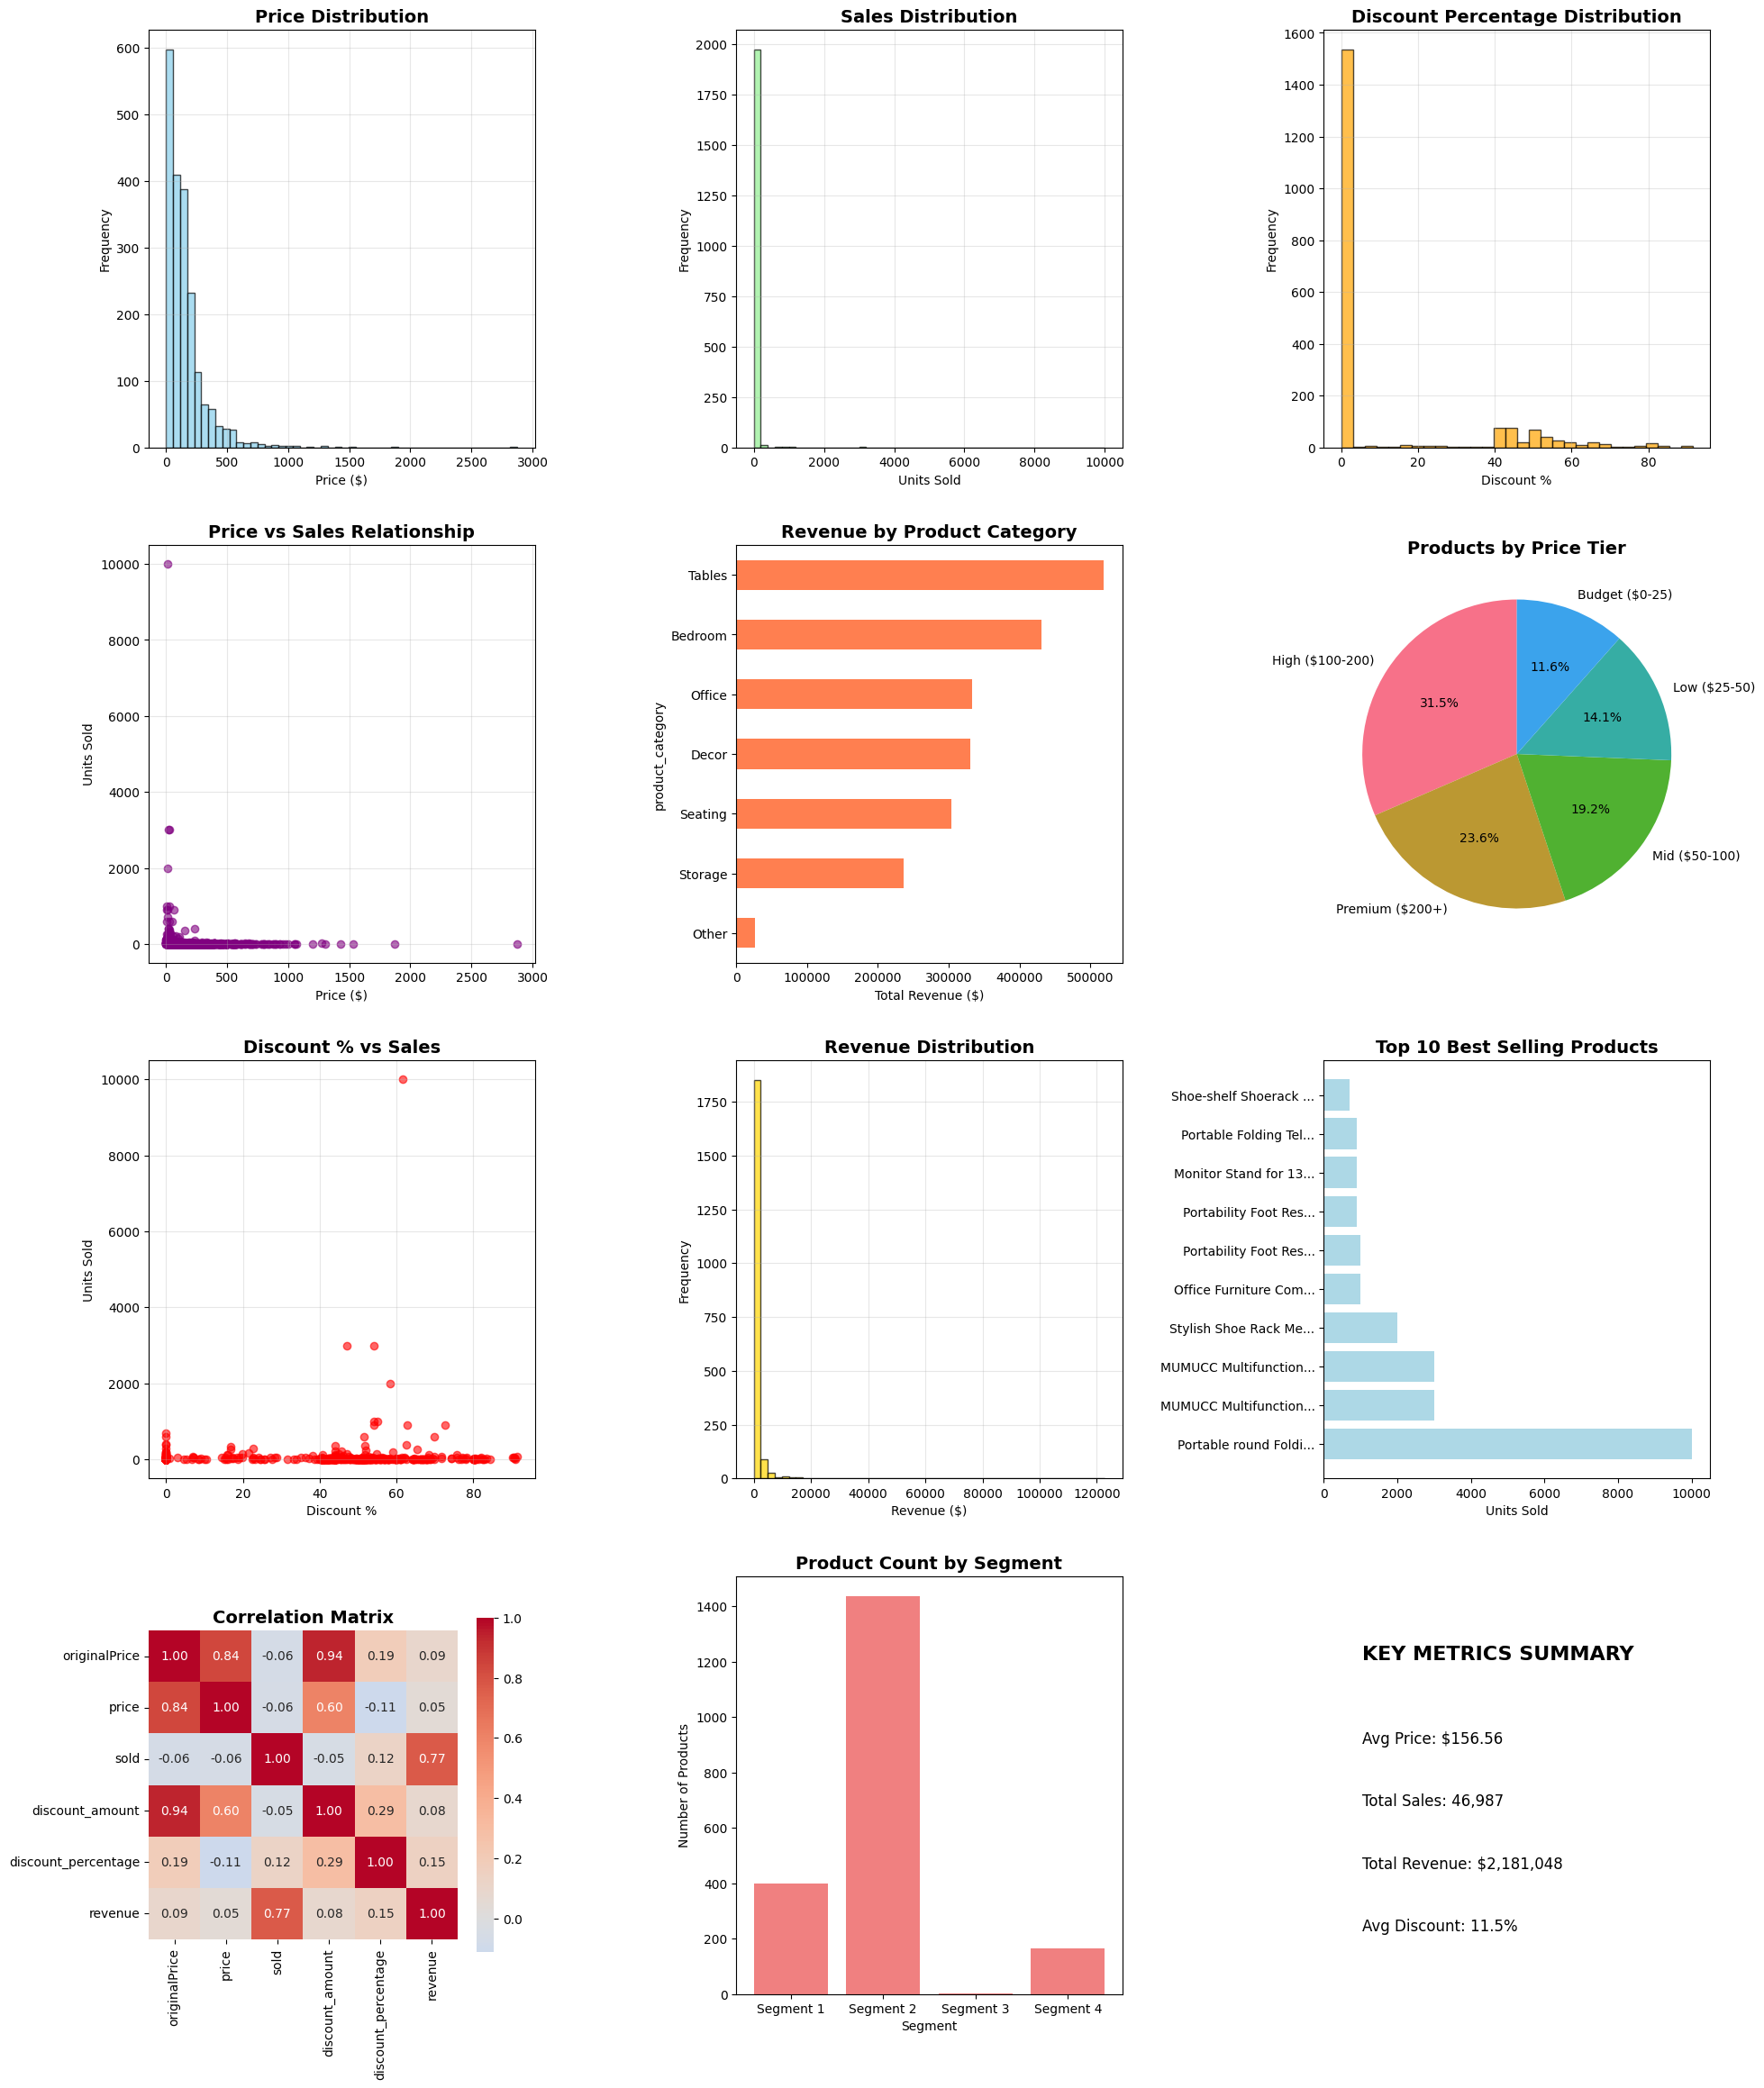

✅ Visualizations generated and saved as 'furniture_analysis_comprehensive.png'

EXECUTIVE SUMMARY
📈 KEY PERFORMANCE INDICATORS:
  • Total Products Analyzed: 2,000
  • Total Revenue Generated: $2,181,048.07
  • Average Product Price: $156.56
  • Total Units Sold: 46,987
  • Average Discount Rate: 11.5%
  • Revenue per Product: $1090.52
  • Units per Product: 23.5

🔍 KEY INSIGHTS:
  • Moderate discounting strategy: Balanced approach to pricing
  • Revenue impact of discounts: 40.5% potential revenue lost
  • Top performing category: Tables (23.8% of revenue)
  • Price neutrality: Price has minimal impact on sales volume
  • Predictive modeling: Linear Regression achieves 1.3% accuracy

💡 STRATEGIC RECOMMENDATIONS:
  1. Prioritize investment in Tables category (highest revenue)
  2. Address high percentage of non-selling products - consider inventory optimization
  3. Implement segment-specific marketing strategies based on identified customer segments

📊 DATA QUALITY ASSESSMENT:
  • Over

,productTitle,originalPrice,price,sold,tagText,discount_amount,discount_percentage,price_tier
0,Dresser For Bedroom With 9 Fabric Drawers Ward...,NaN,46.79,600,Free shipping,NaN,0.00,Low ($25-50)
1,Outdoor Conversation Set 4 Pieces Patio Furnit...,NaN,169.72,0,Free shipping,NaN,0.00,High ($100-200)
2,Desser For Bedroom With 7 Fabric Drawers Organ...,78.40,39.46,7,Free shipping,38.94,49.67,Low ($25-50)
3,"Modern Accent Boucle Chair,Upholstered Tufted ...",NaN,111.99,0,Free shipping,NaN,0.00,High ($100-200)
4,Small Unit Simple Computer Desk Household Wood...,48.82,21.37,1,Free shipping,27.45,56.23,Budget ($0-25)
...,...,...,...,...,...,...,...,...
1995,Modern TV Stand Entertainment Center with Two ...,NaN,72.49,8,Free shipping,NaN,0.00,Mid ($50-100)
1996,"Large Wardrobe Armoire Closet with 3 Doors, Fr...",NaN,276.65,2,Free shipping,NaN,0.00,Premium ($200+)
1997,"Velvet Futon Sofa Bed, 73-inch Sleeper Couch w...",NaN,196.44,10,Free shipping,NaN,0.00,High ($100-200)
1998,Furniture Acrylic Coffee Table Transparent Liv...,NaN,228.18,0,Free shipping,NaN,0.00,Premium ($200+)


In [2]:
# Simple usage
pipeline = FurnitureAnalysisPipeline("ecommerce_furniture_dataset_2024-.csv")
results = pipeline.run_full_analysis()

# Or run individual components
pipeline.load_and_explore_data()
pipeline.analyze_pricing_strategy()
# ... etc